# Task 1
> Prepare files with coordinates of CpG islands, Shores, Shelves and Seas in BEDformat. Please use only autosomal chromosomes

Definitions:
- Shores: CpG islands borders +- 2kb
- Shelves: Shores borders +- 2kb
- Seas: Between shelves

In [ ]:
autosomal_chromosomes = [f'chr{i}' for i in range(1,23)]
shore_size = 2000
shelve_size = 2000

In [ ]:
def get_chromosomes_sizes():
    with open('./data/hg19.chrom.sizes') as f:
        lines = f.readlines()
    return dict((x, int(y)) for (x, y) in (line.split('\t') for line in lines) if x in autosomal_chromosomes)

chromosomes_sizes = get_chromosomes_sizes()

In [3]:
from collections import defaultdict
def read_cpg_islands():
    d = defaultdict(list)
    with open('./data/cpgIslandExt.txt') as f:
        lines = f.readlines()
    for line in lines:
        cols = line.split('\t')
        if cols[1] in autosomal_chromosomes:
            d[cols[1]].append((int(cols[2]), int(cols[3])))
    return d

cpg_islands = read_cpg_islands()

In [4]:
def merge_ranges(*argv):
    ranges = []
    for r in argv:
        ranges = ranges + r
    ranges.sort(key=lambda x: x[0])
    merged = []
    if len(ranges):
        cursor = ranges[0][0]
        i = 0
        while i < len(ranges):
            cursor = ranges[i][0]
            end = ranges[i][1]
            while i < len(ranges) and ranges[i][0] <= end :
                end = max(ranges[i][1], end)
                end = ranges[i][1]
                i += 1
            merged.append((cursor, end))
    return merged


assert([(3485429, 3489051)] == merge_ranges([(3485429,3487429),(3487429,3489051)]))
assert([] == merge_ranges([]))
assert([(1,2)] == merge_ranges([(1,2)]))
assert([(1,3)] == merge_ranges([(1,2),(2,3)]))
assert([(1,3), (4,6)] == merge_ranges([(1,2),(2,3), (4,6)]))
assert([(1000, 3200)] == merge_ranges([(1000, 2000), (1500, 3000), (2500, 3200)]))
assert([(1000, 3000), (3500, 4200)] == merge_ranges([(1000, 2000), (1500, 3000), (3500, 4200)]))


In [5]:
def get_borders(ranges, border_size, max_value):
    borders = []
    i = 0
    cursor = 0
    while i < len(ranges):
        left = max(cursor, ranges[i][0] - border_size)
        right = min(max_value, ranges[i][1] + border_size)
        if i + 1 < len(ranges) and (ranges[i+1][0] - ranges[i][1]) < 2 * border_size:
            right = ranges[i+1][0]
        if left < ranges[i][0] - 1:
            borders.append((left, ranges[i][0]))
        if right > ranges[i][1]:
            borders.append((ranges[i][1], right))
        cursor = right + 1
        i = i + 1
    return borders

assert([] == get_borders([], 20, max_value=100))
assert([(10, 20), (30, 40)] == get_borders([(20, 30)], 10, max_value=100))
assert([(0,10), (20,40)] == get_borders([(10,20)], 20, max_value=100))
assert([(0,10), (20,30)] == get_borders([(10,20)], 20, max_value=30))
assert([(4,10), (20,30), (40, 46), (94,100), (120, 126)] == get_borders([(10,20), (30, 40), (100, 120)], 6, max_value=1000))
assert([(799975,801975), (802338, 805198), (805628, 807628)] == get_borders([(801975, 802338), (805198, 805628)], 2000, max_value = 1000000))

In [6]:
def fill(ranges, max_value):
    result = []
    i = 0
    start = 0
    while i < len(ranges):
        if ranges[i][1] - start > 2:
            result.append((start, ranges[i][0]))
        start = ranges[i][1]
        i += 1
    if start < max_value:
        result.append((start, max_value))
    return result

assert([(0, 100)]==fill([], max_value=100))
assert([(0,10), (20, 100)]==fill([(10,20)], max_value=100))
assert([(0,10), (20, 30)] == fill([(10,20), (30, 40)], max_value=40))    

In [7]:
def get_shores(chromosome_sizes, cpg_islands, shore_size):
    result = {}
    for chromosome in chromosome_sizes:
        chromosome_size = chromosome_sizes[chromosome]
        result[chromosome] = get_borders(cpg_islands[chromosome], shore_size, chromosome_size)
    return result
                
def get_shelves(chromosome_sizes, cpg_islands, shores, shelve_size):
    result = {}
    for chromosome in chromosome_sizes:
        chromosome_size = chromosome_sizes[chromosome]
        ranges = merge_ranges(cpg_islands[chromosome], shores[chromosome])
        result[chromosome] = get_borders(ranges, shelve_size, chromosome_size)
    return result

def get_seas(chromosome_sizes, cpg_islands, shores, shelves):
    result = {}
    for chromosome in chromosome_sizes:
        ranges = merge_ranges(cpg_islands[chromosome], shores[chromosome], shelves[chromosome])
        result[chromosome] = fill(ranges, chromosome_sizes[chromosome])
    return result

In [8]:
shores = get_shores(chromosomes_sizes, cpg_islands, shore_size)
shelves = get_shelves(chromosomes_sizes, cpg_islands, shores, shelve_size)
seas = get_seas(chromosomes_sizes, cpg_islands, shores, shelves)

In [9]:
def save_file(mappings, file_name):
    with open(f'./output/{file_name}.bed','w',encoding='utf-8') as f:
        # for chromosome in autosomal_chromosomes:
        for chromosome in mappings:
            for start, end in mappings[chromosome]:
                f.write(f'{chromosome}\t{start}\t{end}\n')

save_file(cpg_islands, 'cpg_islands')
save_file(shores, 'shores')
save_file(shelves, 'shelves')
save_file(seas, 'seas')

# Task 2

> Set DNA Methylation coordinates as the middle of its range

In [10]:
def get_dna_methylation_centers():
    result = defaultdict(list)
    with open(f'./data/HAIB.A549.EtOH.Rep.3.bed') as f:
        for line in f.readlines():
            if line:
                cols = line.split('\t')
                if cols[0] in autosomal_chromosomes:
                    result[cols[0]].append((int(cols[1]) + int(cols[2])) / 2)
    return result

dna_methylation_centers = get_dna_methylation_centers()

# Task 3

> Find how many DNA Methylations are located in CpG islands, Shores, Shelves and Seas and show results using chart with information about percentage and number of methylations in regions

In [11]:
def is_in_range(position, ranges):
    if not ranges:
        return False
    low = 0
    high = len(ranges) - 1
    i = 0
    while low <= high:
        mid = (low + high) // 2
        if ranges[mid][1] < position:
            low = mid + 1
        elif ranges[mid][0] > position:
            high = mid - 1
        else:
            return ranges[mid][0] <= position and position < ranges[mid][1]
    return False
        
    
assert(not is_in_range(42, []))
assert(is_in_range(42, [(1, 50)]))
assert(is_in_range(1, [(1, 50)]))
assert(not is_in_range(50, [(1, 50)]))
assert(is_in_range(49, [(1, 50)]))
assert(not is_in_range(200, [(1, 50)]))

assert(not is_in_range(50, [(1,10), (20, 30), (40, 50), (60, 70), (80,90)]))
assert(not is_in_range(55, [(1,10), (20, 30), (40, 50), (60, 70), (80,90)]))
assert(is_in_range(45, [(1,10), (20, 30), (40, 50), (60, 70), (80,90)]))

In [12]:
from collections import Counter
def get_hits(dna_methylation_centers, cpg_islands, shores, shelves, seas):
    counter = Counter()
    for chromosome in dna_methylation_centers:
        for position in dna_methylation_centers[chromosome]:
            if is_in_range(position, cpg_islands[chromosome]):
                counter['cpg_island'] += 1
            elif is_in_range(position, shores[chromosome]):
                counter['shore'] += 1
            elif is_in_range(position, shelves[chromosome]):
                counter['shelve'] += 1
            elif is_in_range(position, seas[chromosome]):
                counter['sea'] += 1
            else:
                counter['unknown'] += 1
    return counter

hits = get_hits(dna_methylation_centers, cpg_islands, shores, shelves, seas)
    

In [13]:
import pandas as pd
import numpy as np

df = pd.DataFrame({
    'region': list(hits.keys()),
    'hits': list(hits.values())
})

all_hits_count = df['hits'].sum()
df['frequency'] = [value / all_hits_count for value in df['hits'].values]
df = df.sort_values(by=['frequency'], ascending=False).copy()
df = df.reset_index()


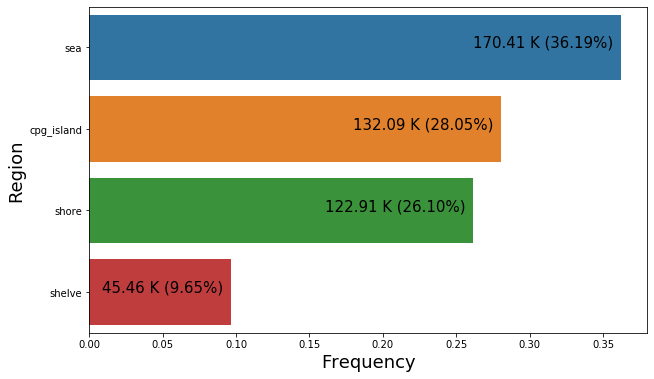

In [40]:
# %matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10,6))
g=sns.barplot(x='frequency',y='region',data=df)
for index, row in df.iterrows():
    g.text(row.frequency - 0.005, row.name , f'{row.hits/1000:4.2f} K ({row.frequency*100:2.2f}%)', color='black', ha='right', fontsize=15)
# g.set(xlabel='common xlabel', ylabel='common ylabel',ylabelsize=15)
g.set_xlabel('Frequency', fontsize=18)
g.set_ylabel('Region', fontsize=18)
plt.show()
